# Starting Point:
First, we import all of the necessary python modules.

In [1]:
import sqlite3 #getting data from .db files
import pandas as pd #working with DataFrames
import seaborn as sns #making visualizations
import matplotlib.pyplot as plt #making and exporting visualizations
import copy #copying dataframes properly
import time #interpretting datetime strings
import numpy as np #correlation analysis
import string #useful library for dealing with strings
import warnings
warnings.filterwarnings('ignore')

We also create the sql database with the code below.

In [2]:
from src.make_db import create_movies_db

In [3]:
create_movies_db()

imdb_title_principals table created successfully....
imdb_name_basic table created successfully....
imdb_title_crew table created successfully....
imdb_title_ratings table created successfully....
imdb_title_basics table created successfully....
imdb_title_akas table created successfully....
tn_movie_budgets table created successfully....
tmdb_movies table created successfully....
bom_movie_gross table created successfully....
rotten_tomatoes_critic_reviews table created successfully....
rotten_tomatoes_movies table created successfully....
Inserting data into the imdb_title_crew table....
Inserting data into the tmdb_movies table....
Inserting data into the imdb_title_akas table....
Inserting data into the imdb_title_ratings table....
Inserting data into the imdb_name_basics table....
Inserting data into the rotten_tomatoes_movies table....
Inserting data into the rotten_tomatoes_critic_reviews table....
Inserting data into the imdb_title_basics table....
Inserting data into the tn_mo

![movies.db schema](images/movies_db_schema.png)

# Part 1: The Rotten Tomatoes Tables
The first tables that we use is from the Rotten Tomatoes website. These are valuable as they collect reviews and ratings' scores from various locations online for tons of films.

## Cleaning the tables
Here, we import the datatables to DataFrames using SQL.

In [4]:
conn = sqlite3.connect('data/movies.db')

df_r = pd.read_sql('''
select * from rotten_tomatoes_critic_reviews
''', conn) #_r stands for reviews

df_m = pd.read_sql('''
select * from rotten_tomatoes_movies
''', conn) #_m stands for movies

Let's start with the reviews table. We use `.shape` and `.head()` to take a peek.

In [5]:
print(df_r.shape)
df_r.head()

(1130017, 9)


,idx,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,0,m/0814255,Andrew L. Urban,0,Urban Cinefile,Fresh,None,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,1,m/0814255,Louise Keller,0,Urban Cinefile,Fresh,None,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,2,m/0814255,None,0,FILMINK (Australia),Fresh,None,2010-02-09,With a top-notch cast and dazzling special eff...
3,3,m/0814255,Ben McEachen,0,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,4,m/0814255,Ethan Alter,1,Hollywood Reporter,Rotten,None,2010-02-10,What's really lacking in The Lightning Thief i...


We'll immediately drop the `critic_name` and `review_content` columns, as they aren't useful without natural language processing. The `idx` column can also go.

In [6]:
df_r.drop(['critic_name','review_content','idx'], axis = 1, inplace = True) #drops review_content from the columns

Now we check for null values (we can already see a couple in the `review_score` column above).

In [7]:
df_r.isna().sum() #returns a count of null values for each column

rotten_tomatoes_link         0
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
dtype: int64

As all of the missing values are in review_score, let's take a peek at these values.

In [8]:
df_r['review_score'] #display just the review_score column

0           None
1           None
2           None
3          3.5/5
4           None
           ...  
1130012      2/5
1130013    3.5/5
1130014       B+
1130015    3.5/5
1130016        C
Name: review_score, Length: 1130017, dtype: object

It appears that a lot of the values are strings in the form `Points/Total`. Others are in the form of a letter grade. Let's tackle these.

We start by investigating what all letter grades are being used.

In [9]:
def has_letter(str_input): #make a function to tell if the input has a letter
    for char in str_input:
        if char in string.ascii_uppercase:
            return True
        
    return False

df_r.loc[df_r['review_score'].map(lambda x: has_letter(x) if x != None else False), 'review_score'].value_counts()
#The above uses the has_letter function to return every value in the column with a letter (None doesn't
#have a letter and is thus excluded).

B       24358
B+      19822
B-      15754
C       14329
A-      11410
C+      10863
A        9482
C-       9449
D        6148
D+       3802
F        1896
D-       1605
C  -        3
A  -        1
Name: review_score, dtype: int64

Let's make a dictionary of these values and corresponding scores from 0 to 1. Also make note of the few `C -` and `A -` scores that erroneously contain spaces.

In [10]:
score_tuple = ('F','D-','D','D+','C-','C','C+','B-','B','B+','A-','A')
scores = np.linspace(0, 1, len(score_tuple)) #evenly spaced values from 0 to 1

score_map = dict(zip(score_tuple, scores))
print(score_map)

{'F': 0.0, 'D-': 0.09090909090909091, 'D': 0.18181818181818182, 'D+': 0.2727272727272727, 'C-': 0.36363636363636365, 'C': 0.4545454545454546, 'C+': 0.5454545454545454, 'B-': 0.6363636363636364, 'B': 0.7272727272727273, 'B+': 0.8181818181818182, 'A-': 0.9090909090909092, 'A': 1.0}


Now we write a function that will convert all of the letter grades to the appropriate score, as well as do the division needed for all of the scores in the `Points/Total` format.

In [11]:
def percent(strscore):
    if strscore is None:
        return strscore #we aren't tackling Nones yet
    for character in strscore: #check for letter grades
        if character in string.ascii_uppercase:
            return score_map[strscore.replace(' ','')] #some letter grades have stray spaces, remember?
        
    components = strscore.split('/')
    
    if len(components) == 2: #just to make sure that the format is proper.
        if float(components[1]) == 0: #avoid erroneously dividing by zero. We replaces these with Nones to disregard them later 
            return None
        return float(components[0])/float(components[1])
    else:
        return strscore

Now we apply this function.

In [12]:
df_r['review_score'] = df_r['review_score'].map(percent)
df_r.head()

,rotten_tomatoes_link,top_critic,publisher_name,review_type,review_score,review_date
0,m/0814255,0,Urban Cinefile,Fresh,None,2010-02-06
1,m/0814255,0,Urban Cinefile,Fresh,None,2010-02-06
2,m/0814255,0,FILMINK (Australia),Fresh,None,2010-02-09
3,m/0814255,0,Sunday Mail (Australia),Fresh,0.7,2010-02-09
4,m/0814255,1,Hollywood Reporter,Rotten,None,2010-02-10


Let's do a quick check to see that none of the resulting values are over 1.

In [13]:
df_r['review_score'] = df_r['review_score'].astype(float)
df_r.loc[df_r['review_score'].notna(), 'review_score'].sort_values() #sort the values that aren't Nones/NaNs

398354      0.0
984544      0.0
12166       0.0
612059      0.0
12169       0.0
          ...  
777549     95.0
979139    910.0
923019    910.0
832900    920.0
832901    920.0
Name: review_score, Length: 824079, dtype: float64

It appears that there were some bad entries that didn't contain a `/` to let us know what scale was being used. We'll drop these now.

In [14]:
df_r.loc[df_r['review_score'].notna(), 'review_score'] = df_r.loc[df_r['review_score'].notna(), 'review_score'].map(lambda x: x if x <= 1 else np.nan)
#the above replaces any non-null values over 1 with NaNs

We check to see that all is now well...

In [15]:
df_r.loc[df_r['review_score'].notna(), 'review_score'].sort_values() #sort the values that aren't Nones/NaNs

260269    0.0
396418    0.0
274457    0.0
663892    0.0
274601    0.0
         ... 
916177    1.0
916172    1.0
916171    1.0
916164    1.0
626616    1.0
Name: review_score, Length: 822503, dtype: float64

Now we can tackle null values. In order to preserve the number of data points we have, we will replace all null values with the median value of the `review_score` column for the given movie (identified by the `rotten_tomatoes_link`).

So, we generate a series containing the median `review_score` for each film.

In [16]:
df_med_sc = df_r.loc[df_r['review_score'].notna()].groupby('rotten_tomatoes_link')['review_score'].median()
df_med_sc.head()

rotten_tomatoes_link
m/+_one_2019                       0.7500
m/+h                               0.2875
m/-_man                            0.6250
m/-cule_valley_of_the_lost_ants    0.8000
m/0814255                          0.6000
Name: review_score, dtype: float64

Now, as there is no easy way to access the values of a different series in the middle of a `.map()` function, we will be cheeky and first replace all null values in the `review_score` column with the `rotten_tomatoes_link`.

In [17]:
def check_string(val): #checks if the input is a string
    if type(val) == str:
        return True
    return False

df_r.loc[df_r['review_score'].isna(), 'review_score'] = df_r['rotten_tomatoes_link'] #replacing nulls with links
df_r.loc[df_r['review_score'].map(check_string), ['rotten_tomatoes_link','review_score']].tail(20)
#displaying the link and score columns for any row with a string in the score column
#this is done to check that the replacements happened as intended

,rotten_tomatoes_link,review_score
1129954,m/zootopia,m/zootopia
1129955,m/zootopia,m/zootopia
1129962,m/zootopia,m/zootopia
1129964,m/zootopia,m/zootopia
1129966,m/zootopia,m/zootopia
1129967,m/zootopia,m/zootopia
1129968,m/zootopia,m/zootopia
1129969,m/zootopia,m/zootopia
1129971,m/zootopia,m/zootopia
1129972,m/zootopia,m/zootopia


Now we can go through the `review_score` column and replace any string value with the median score for that film.

In [18]:
def replace_with_med(score): #defining a function to replace strings with the appropriate median value from the Series we made
    if type(score) == float:
        return score
    elif score in df_med_sc.index:
        return df_med_sc[score]
    else:
        return None
    
df_r['review_score'] = df_r['review_score'].map(replace_with_med) #using the function to fix the review scores
df_r['review_score'].map(lambda x: type(x)).value_counts() #checking what kind of values remain

<class 'float'>    1130017
Name: review_score, dtype: int64

Nice! Only `float`s remain. Let's double check to be sure:

In [19]:
df_r.isna().sum()

rotten_tomatoes_link      0
top_critic                0
publisher_name            0
review_type               0
review_score            238
review_date               0
dtype: int64

This likely means certain films didn't have any reviews without null scores from the beginning, and thus they did not appear in the median score Series we made. We'll drop these, as they were never useful in the first place.

In [20]:
df_r.dropna(inplace = True)
print(df_r.shape) #to get a feel for how many values were lost
df_r.isna().sum()

(1129779, 6)


rotten_tomatoes_link    0
top_critic              0
publisher_name          0
review_type             0
review_score            0
review_date             0
dtype: int64

Hardly any records were lost. Now, let's work on the `review_date` column, converting it to a `datetime` object. First, we check the format of the `review_date` strings.

In [21]:
df_r['review_date'].head()

0    2010-02-06
1    2010-02-06
2    2010-02-09
3    2010-02-09
4    2010-02-10
Name: review_date, dtype: object

Now, we convert these.

In [22]:
df_r['review_date'] = df_r['review_date'].map(lambda x: time.strptime(x, "%Y-%m-%d"))

Now, we move on to cleaning the movies table. To refresh our memory, let's take a peek:

In [23]:
print(df_m.shape)
df_m.head()

(17712, 23)


,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


Let's drop all the columns that we won't be using.

In [24]:
df_m.drop(['critics_consensus','movie_info','tomatometer_top_critics_count',
           'tomatometer_fresh_critics_count','tomatometer_rotten_critics_count','idx'], axis = 1, inplace = True)

Now we check for nulls.

In [25]:
df_m.isna().sum()

rotten_tomatoes_link         0
movie_title                  0
content_rating               0
genres                      19
directors                  194
authors                   1542
actors                     352
original_release_date     1166
streaming_release_date     384
runtime                    314
production_company         499
tomatometer_status          44
tomatometer_rating          44
tomatometer_count           44
audience_status            448
audience_rating            296
audience_count             297
dtype: int64

There's no simple way to replace missing values with central values, as each movie should appear only once. Additionally, many of the missing values are categorical or text based. So, we simply drop these.

In [26]:
df_m.dropna(inplace = True)
df_m.isna().sum()

rotten_tomatoes_link      0
movie_title               0
content_rating            0
genres                    0
directors                 0
authors                   0
actors                    0
original_release_date     0
streaming_release_date    0
runtime                   0
production_company        0
tomatometer_status        0
tomatometer_rating        0
tomatometer_count         0
audience_status           0
audience_rating           0
audience_count            0
dtype: int64

Let's also quickly convert the two date columns to `datetime`.

In [27]:
df_m['original_release_date'] = df_m['original_release_date'].map(lambda x: time.strptime(x, "%Y-%m-%d"))
df_m['streaming_release_date'] = df_m['streaming_release_date'].map(lambda x: time.strptime(x, "%Y-%m-%d"))

A quick check for duplicates..

In [28]:
df_m.loc[df_m.duplicated(['movie_title','original_release_date'])]

,rotten_tomatoes_link,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count


Now that we've mostly cleaned both Rotten Tomatoes tables, we can join them using the `rotten_tomatoes_link` column

In [29]:
df_rot = df_m.set_index('rotten_tomatoes_link').join(df_r.set_index('rotten_tomatoes_link'), how = 'left')
print(df_rot.shape)
df_rot.head()

(1003058, 21)


,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,49.0,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,0.6,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)"
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,49.0,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,0.6,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)"
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,49.0,149.0,Spilled,53.0,254421.0,0.0,FILMINK (Australia),Fresh,0.6,"(2010, 2, 9, 0, 0, 0, 1, 40, -1)"
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,49.0,149.0,Spilled,53.0,254421.0,0.0,Sunday Mail (Australia),Fresh,0.7,"(2010, 2, 9, 0, 0, 0, 1, 40, -1)"
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,49.0,149.0,Spilled,53.0,254421.0,1.0,Hollywood Reporter,Rotten,0.6,"(2010, 2, 10, 0, 0, 0, 2, 41, -1)"


One last check for nulls:

In [30]:
df_rot.isna().sum()

movie_title                0
content_rating             0
genres                     0
directors                  0
authors                    0
actors                     0
original_release_date      0
streaming_release_date     0
runtime                    0
production_company         0
tomatometer_status         0
tomatometer_rating         0
tomatometer_count          0
audience_status            0
audience_rating            0
audience_count             0
top_critic                17
publisher_name            17
review_type               17
review_score              17
review_date               17
dtype: int64

As there are so few, we drop them.

In [31]:
df_rot.dropna(inplace = True)

## Working with the combined table

Let's do some further cleaning up and finally get to some useful visualizations. First, we convert the `genres`, `directors`,`authors`, and `actors` columns to list form.

In [32]:
def listize(stringlist): #function to turn a string into a list
    if stringlist == None:
        return []
    list_version = stringlist.split(', ')
    return list_version

def columnlister(listcols): #function to make the process a little smoother by converting each column we give it
    for col in listcols:
        df_rot[col] = df_rot[col].map(listize)
        
columnlister(['genres','directors','authors','actors'])

We quickly check that this worked.

In [33]:
print(type(df_rot['genres'].iloc[0]), type(df_rot['directors'].iloc[0]))
print(type(df_rot['authors'].iloc[0]), type(df_rot['actors'].iloc[0]))

<class 'list'> <class 'list'>
<class 'list'> <class 'list'>


Now lets quickly filter out anything with a `runtime` below 45 minutes. We're not interested in short films.

In [34]:
df_rot = df_rot.loc[df_rot['runtime'] >= 45]
df_rot.shape #to check how many values are lost

(1002588, 21)

We can similarly disregard any film with an `audience_count` below that of the 50th percentile. We aren't interested in any film that doesn't reach the mainstream.

In [35]:
df_rot = df_rot.loc[df_rot['audience_count'] >= df_rot['audience_count'].quantile(.50)]
df_rot.shape #to check how many values are lost

(501322, 21)

Now, let's convert the `review_score` column to a score out of 5.

In [36]:
df_rot['review_score'] = df_rot['review_score']*5
df_rot['review_score'].head() #to check

rotten_tomatoes_link
m/0814255    3.0
m/0814255    3.0
m/0814255    3.0
m/0814255    3.5
m/0814255    3.0
Name: review_score, dtype: float64

We add a column called `fresh_bool` which is a boolean corresponding to wheter or not the review is fresh.

In [37]:
df_rot['fresh_bool'] = df_rot['review_type'].map(lambda x: x == 'Fresh')

Now, we explode the genres column for closer inspection.

In [38]:
df_rgen = df_rot.explode('genres')
print(df_rgen.shape)
df_rgen.head()

(1141115, 22)


,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date,fresh_bool
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,Action & Adventure,[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,3.0,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)",True
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,Comedy,[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,3.0,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)",True
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,Drama,[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,3.0,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)",True
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,Science Fiction & Fantasy,[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,3.0,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)",True
m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,Action & Adventure,[Chris Columbus],"[Craig Titley, Chris Columbus, Rick Riordan]","[Logan Lerman, Brandon T. Jackson, Alexandra D...","(2010, 2, 12, 0, 0, 0, 4, 43, -1)","(2015, 11, 25, 0, 0, 0, 2, 329, -1)",119.0,20th Century Fox,...,149.0,Spilled,53.0,254421.0,0.0,Urban Cinefile,Fresh,3.0,"(2010, 2, 6, 0, 0, 0, 5, 37, -1)",True


In preparation for a graph, we created a Series of median `review_score`s when grouped by `genres`. Additionally, this Series will exclude any genres that have fewer than 25 movies, as these can easily be considered flukes or passing trends.

In [39]:
df_drop_gen = df_rgen.groupby('genres')['movie_title'].nunique() #we count the number of unique films in each genre
drop_list = [gen for gen in df_drop_gen.index if df_drop_gen[gen] < 25]
drop_list #let's take a look at the list we made

['Anime & Manga',
 'Cult Movies',
 'Faith & Spirituality',
 'Gay & Lesbian',
 'Sports & Fitness',
 'Television']

First, lets make a function to make a color that highlights the genres of interest: Musicals and Animations. We do this now to avoid dealing with the `'\n'` replacement that happens later.

In [40]:
def colorlist(genrelist):
    palette = {}
    for genre in genrelist:
        if 'Musical' in genre:
            palette[genre] = 'purple'
        elif 'Animation' in genre:
            palette[genre] = 'red'
        else:
            palette[genre] = 'blue'
    return palette

Now we can actually make the Series.

In [41]:
df_g_sc = df_rgen.groupby('genres')['review_score'].median().sort_values(ascending = False)
df_g_sc.drop(drop_list, inplace = True) #here we drop the genres we found above
df_g_sc.index = df_g_sc.index.map(lambda x: x.replace(' ','\n')) #this is to make the graph look cleaner. Replace spaces with new lines
df_g_sc.head()

genres
Classics                        4.287500
Art\nHouse\n&\nInternational    4.000000
Special\nInterest               3.750000
Documentary                     3.750000
Animation                       3.636364
Name: review_score, dtype: float64

Let's plot this information now.

In [42]:
sns.set_theme()

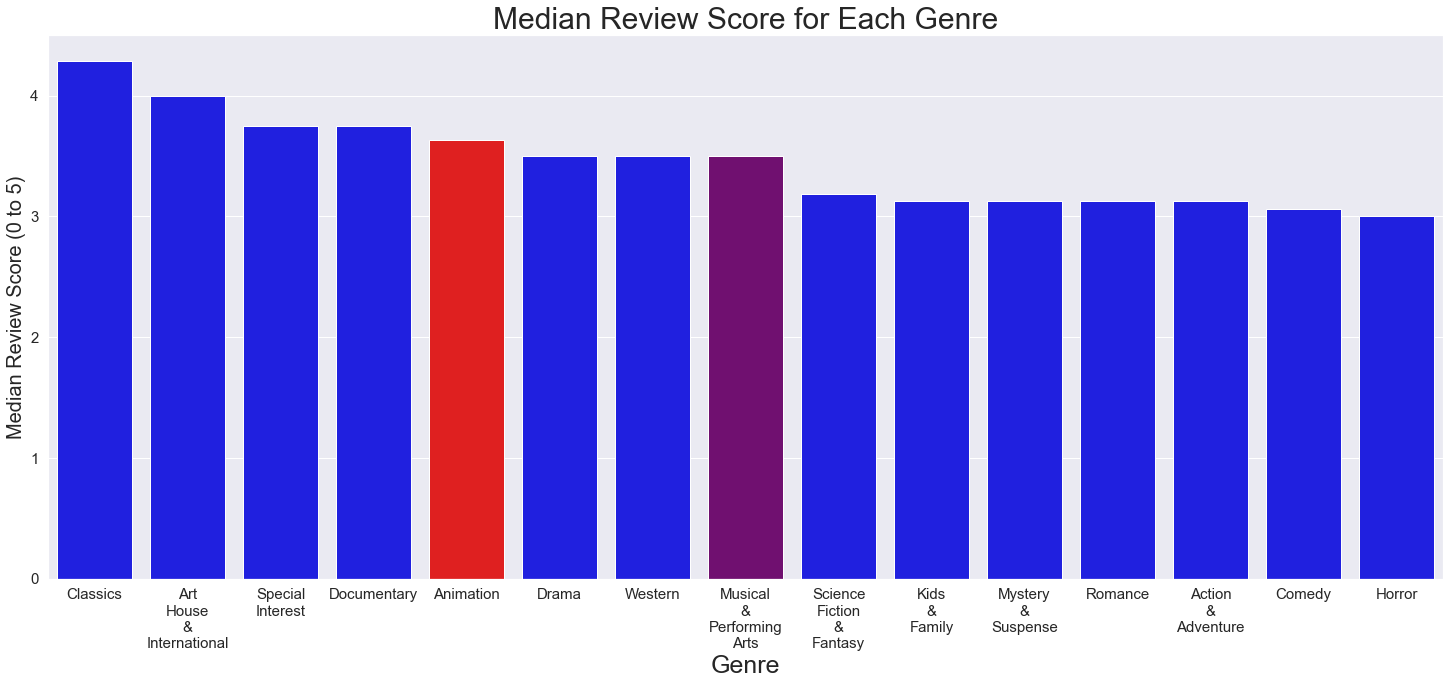

In [43]:
fig, ax = plt.subplots(figsize = (25,10))
ax = sns.barplot(x = df_g_sc.index, y = df_g_sc.values, palette = colorlist(df_g_sc.index))

ax.set_title('Median Review Score for Each Genre', fontsize = 30)
ax.set_xlabel('Genre', fontsize = 25)
ax.set_ylabel('Median Review Score (0 to 5)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/median_sc_gen');

Now let's make a boxplot of the review scores for each genre

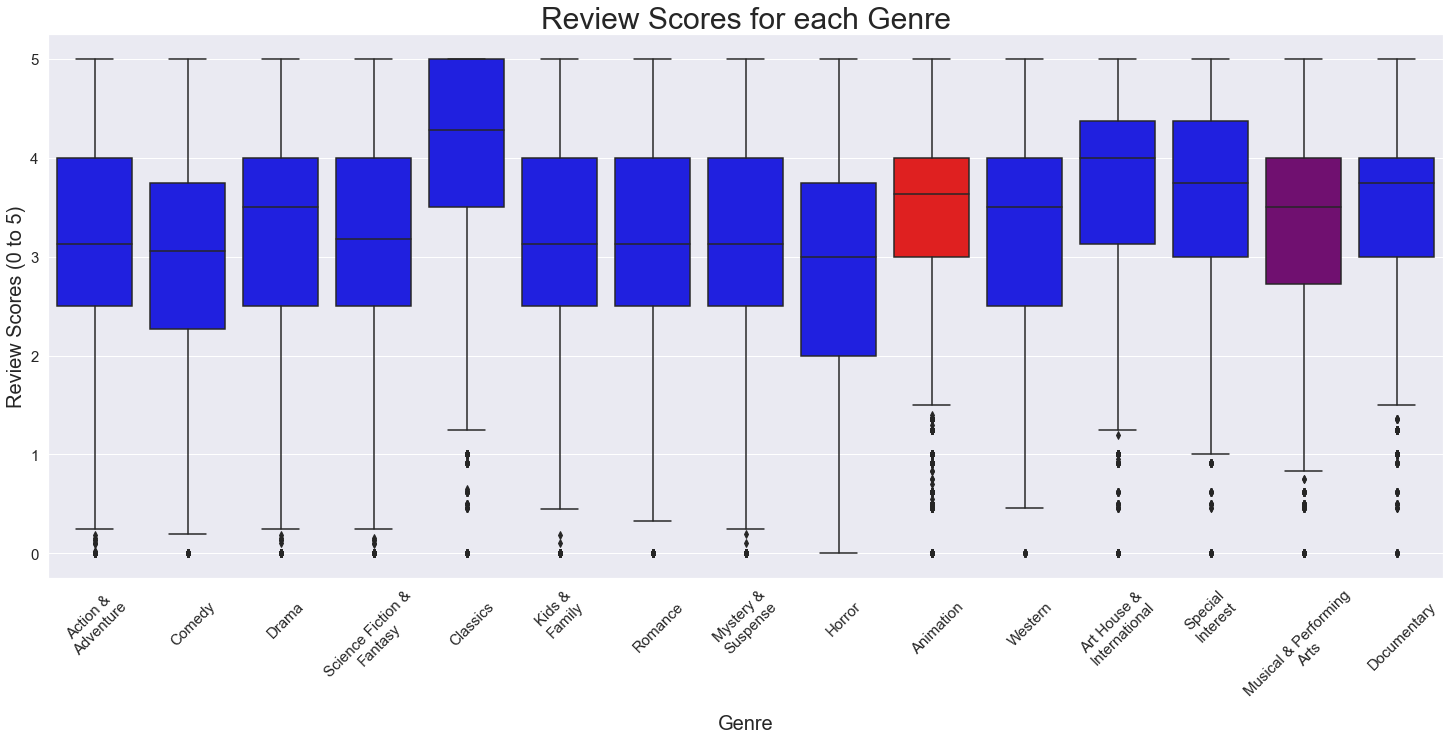

In [44]:
df_genre_edit = copy.deepcopy(df_rgen) #making a copy so we can clean the genre names
df_genre_edit = df_genre_edit.loc[~df_genre_edit['genres'].isin(drop_list)]
df_genre_edit['genres'] = df_genre_edit['genres'].map(lambda x: ' '.join(x.split()[:-1])+'\n'+x.split()[-1]) #cleaning names here

fig2, ax2 = plt.subplots(figsize = (25,10))
ax2 = sns.boxplot(data = df_genre_edit, x = 'genres', y = 'review_score', palette = colorlist(df_genre_edit['genres'].unique()))

ax2.set_title('Review Scores for each Genre', fontsize = 30)
ax2.set_xlabel('Genre', fontsize = 20)
ax2.set_ylabel('Review Scores (0 to 5)', fontsize = 20)
plt.xticks(rotation = 45)
ax2.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/box_sc_gen');

Finally, we make a graph of the "freshness" of each of the genres. We make the grouped series first...

In [45]:
df_g_fb = df_rgen.groupby('genres')['fresh_bool'].mean().sort_values(ascending = False)
df_g_fb.drop(drop_list, inplace = True) #dropping fluke genres
df_g_fb.index = df_g_fb.index.map(lambda x: x.replace(' ','\n')) #cleaning names again
df_g_fb.head()

genres
Classics                        0.825818
Art\nHouse\n&\nInternational    0.802087
Documentary                     0.766400
Special\nInterest               0.763573
Animation                       0.714584
Name: fresh_bool, dtype: float64

And then we plot it.

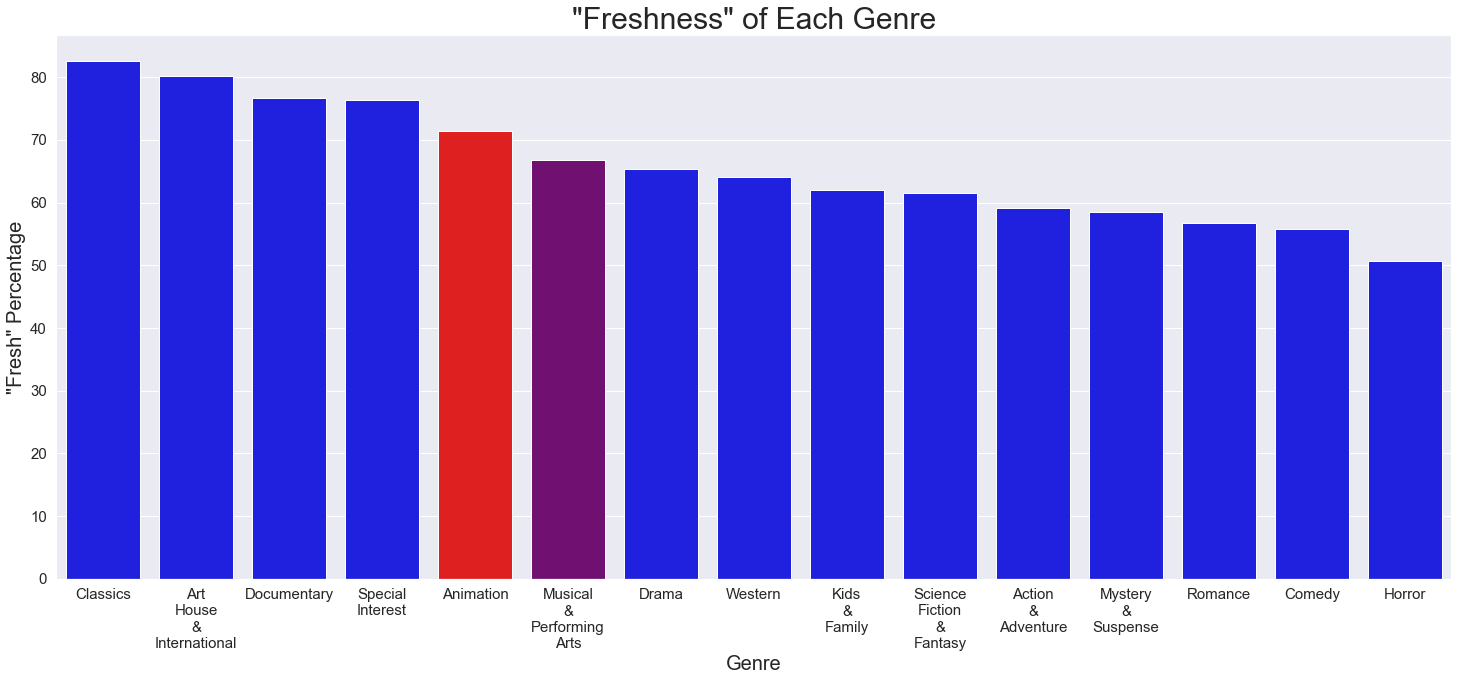

In [46]:
fig3, ax3 = plt.subplots(figsize = (25,10))
ax3 = sns.barplot(x = df_g_fb.index, y = df_g_fb.values*100, palette = colorlist(df_g_fb.index)) #the '*100' changes these decimals to percentages

ax3.set_title('"Freshness" of Each Genre', fontsize = 30)
ax3.set_xlabel('Genre', fontsize = 20)
ax3.set_ylabel('"Fresh" Percentage', fontsize = 20)
ax3.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/genre_fresh');

Let's now investigate the most popular actors for animation and musicals

In [47]:
df_ract = df_rgen.loc[df_rgen['genres'].isin(['Animation','Musical & Performing Arts'])].explode('actors')
df_ract.head()

,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date,fresh_bool
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/10004659-arthur,Arthur and the Invisibles (Arthur and the Mini...,PG,Animation,[Luc Besson],"[Luc Besson, Celine Garcia]",Freddie Highmore,"(2007, 1, 12, 0, 0, 0, 4, 12, -1)","(2016, 8, 10, 0, 0, 0, 2, 223, -1)",94.0,MGM,...,92.0,Spilled,56.0,134483.0,0.0,Slant Magazine,Fresh,3.75,"(2006, 12, 26, 0, 0, 0, 1, 360, -1)",True
m/10004659-arthur,Arthur and the Invisibles (Arthur and the Mini...,PG,Animation,[Luc Besson],"[Luc Besson, Celine Garcia]",Mia Farrow,"(2007, 1, 12, 0, 0, 0, 4, 12, -1)","(2016, 8, 10, 0, 0, 0, 2, 223, -1)",94.0,MGM,...,92.0,Spilled,56.0,134483.0,0.0,Slant Magazine,Fresh,3.75,"(2006, 12, 26, 0, 0, 0, 1, 360, -1)",True
m/10004659-arthur,Arthur and the Invisibles (Arthur and the Mini...,PG,Animation,[Luc Besson],"[Luc Besson, Celine Garcia]",Penny Balfour,"(2007, 1, 12, 0, 0, 0, 4, 12, -1)","(2016, 8, 10, 0, 0, 0, 2, 223, -1)",94.0,MGM,...,92.0,Spilled,56.0,134483.0,0.0,Slant Magazine,Fresh,3.75,"(2006, 12, 26, 0, 0, 0, 1, 360, -1)",True
m/10004659-arthur,Arthur and the Invisibles (Arthur and the Mini...,PG,Animation,[Luc Besson],"[Luc Besson, Celine Garcia]",Doug Rand,"(2007, 1, 12, 0, 0, 0, 4, 12, -1)","(2016, 8, 10, 0, 0, 0, 2, 223, -1)",94.0,MGM,...,92.0,Spilled,56.0,134483.0,0.0,Slant Magazine,Fresh,3.75,"(2006, 12, 26, 0, 0, 0, 1, 360, -1)",True
m/10004659-arthur,Arthur and the Invisibles (Arthur and the Mini...,PG,Animation,[Luc Besson],"[Luc Besson, Celine Garcia]",David Bowie,"(2007, 1, 12, 0, 0, 0, 4, 12, -1)","(2016, 8, 10, 0, 0, 0, 2, 223, -1)",94.0,MGM,...,92.0,Spilled,56.0,134483.0,0.0,Slant Magazine,Fresh,3.75,"(2006, 12, 26, 0, 0, 0, 1, 360, -1)",True


Let's generate a similar drop list to before.

In [48]:
df_drop_act = df_ract.groupby('actors')['movie_title'].nunique()
drop_list_act = [act for act in df_drop_act.index if df_drop_act[act] <= 10]

Now we find the median review score for each actor not in the drop list.

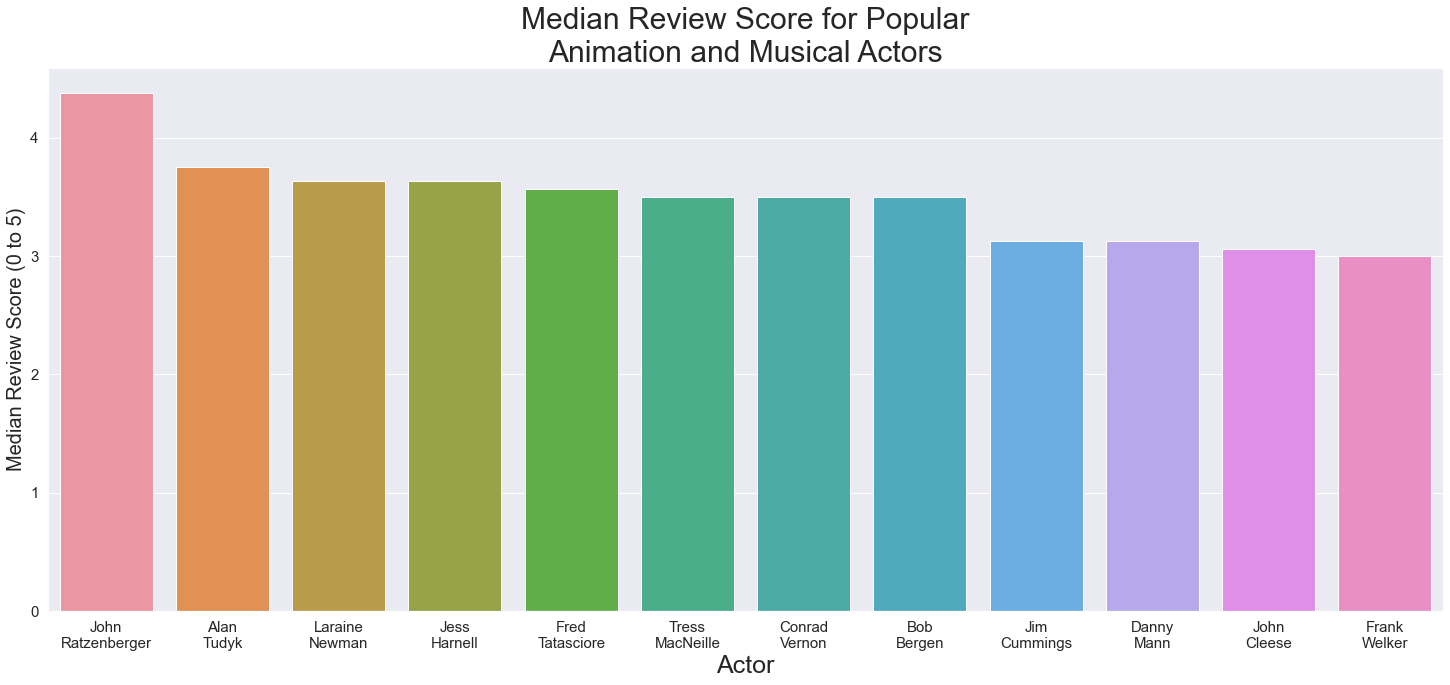

In [49]:
df_ac_sc = df_ract.loc[~df_ract['actors'].isin(drop_list_act)].groupby('actors')['review_score'].median().sort_values(ascending = False)
df_ac_sc.index = df_ac_sc.index.map(lambda x: x.replace(' ','\n')) #fixing names for readability

fig4, ax4 = plt.subplots(figsize=(25,10))
ax4 = sns.barplot(x = df_ac_sc.index, y = df_ac_sc.values)

ax4.set_title('Median Review Score for Popular\nAnimation and Musical Actors', fontsize = 30)
ax4.set_xlabel('Actor', fontsize = 25)
ax4.set_ylabel('Median Review Score (0 to 5)', fontsize = 20)
ax4.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/median_sc_act');

Now we repeat these investigations for a only films made after 2016.

In [50]:
cutoff = time.strptime('2016-01-01', '%Y-%m-%d')

df_rotrec = df_rot.loc[df_rot['original_release_date'] >= cutoff]
df_rotrec.head()

,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date,fresh_bool
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,"[Drama, Mystery & Suspense, Science Fiction & ...",[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,0.0,Metro,Fresh,4.000000,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,"[Drama, Mystery & Suspense, Science Fiction & ...",[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,TheWrap,Fresh,4.000000,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,"[Drama, Mystery & Suspense, Science Fiction & ...",[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,Hollywood Reporter,Fresh,4.000000,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,"[Drama, Mystery & Suspense, Science Fiction & ...",[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,Entertainment Weekly,Fresh,3.636364,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,"[Drama, Mystery & Suspense, Science Fiction & ...",[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,Variety,Fresh,4.000000,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True


First, we explode the genres column for closer inspection.

In [51]:
df_recgen = df_rotrec.explode('genres')
print(df_recgen.shape)
df_recgen.head()

(79571, 22)


,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date,fresh_bool
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,Drama,[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,0.0,Metro,Fresh,4.0,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,Mystery & Suspense,[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,0.0,Metro,Fresh,4.0,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,Science Fiction & Fantasy,[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,0.0,Metro,Fresh,4.0,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,Drama,[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,TheWrap,Fresh,4.0,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True
m/10_cloverfield_lane,10 Cloverfield Lane,PG-13,Mystery & Suspense,[Dan Trachtenberg],"[Josh Campbell, Matthew Stuecken, Damien Chaze...","[Mary Elizabeth Winstead, John Goodman, John G...","(2016, 3, 11, 0, 0, 0, 4, 71, -1)","(2016, 5, 31, 0, 0, 0, 1, 152, -1)",103.0,Bad Robot Productions,...,309.0,Upright,79.0,60918.0,1.0,TheWrap,Fresh,4.0,"(2016, 3, 8, 0, 0, 0, 1, 68, -1)",True


In preparation for a graph, we created a Series of median `review_score`s when grouped by `genres`. This time, we won't drop any genres.

In [52]:
df_g_sc_rec = df_recgen.groupby('genres')['review_score'].median().sort_values(ascending = False)
df_g_sc_rec.index = df_g_sc_rec.index.map(lambda x: x.replace(' ','\n')) #this is to make the graph look cleaner. Replace spaces with new lines
df_g_sc_rec.head()

genres
Mystery\n&\nSuspense            3.750000
Musical\n&\nPerforming\nArts    3.750000
Drama                           3.750000
Science\nFiction\n&\nFantasy    3.636364
Animation                       3.636364
Name: review_score, dtype: float64

Let's plot this information now.

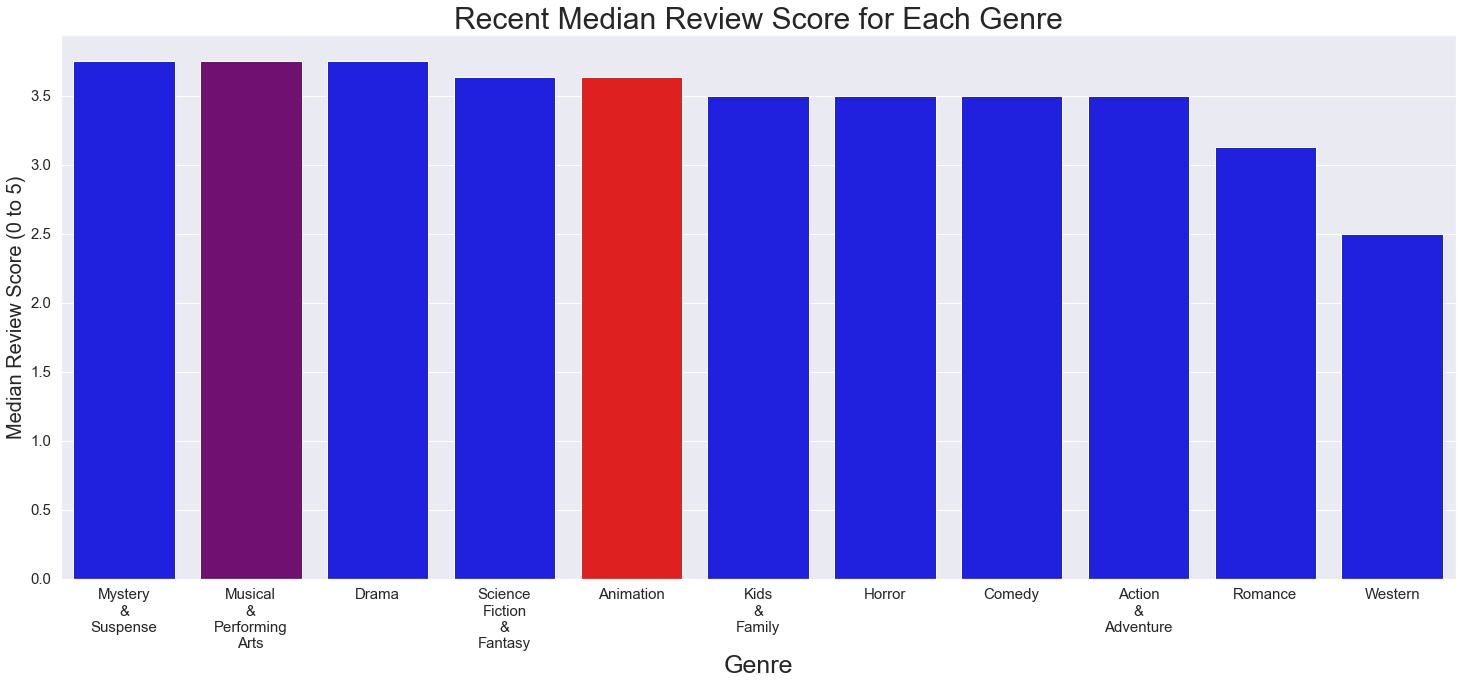

In [53]:
fig5, ax5 = plt.subplots(figsize = (25,10))
ax5 = sns.barplot(x = df_g_sc_rec.index, y = df_g_sc_rec.values, palette = colorlist(df_g_sc_rec.index))

ax5.set_title('Recent Median Review Score for Each Genre', fontsize = 30)
ax5.set_xlabel('Genre', fontsize = 25)
ax5.set_ylabel('Median Review Score (0 to 5)', fontsize = 20)
ax5.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/rec_median_sc_gen');

Now let's make a boxplot of the review scores for each genre

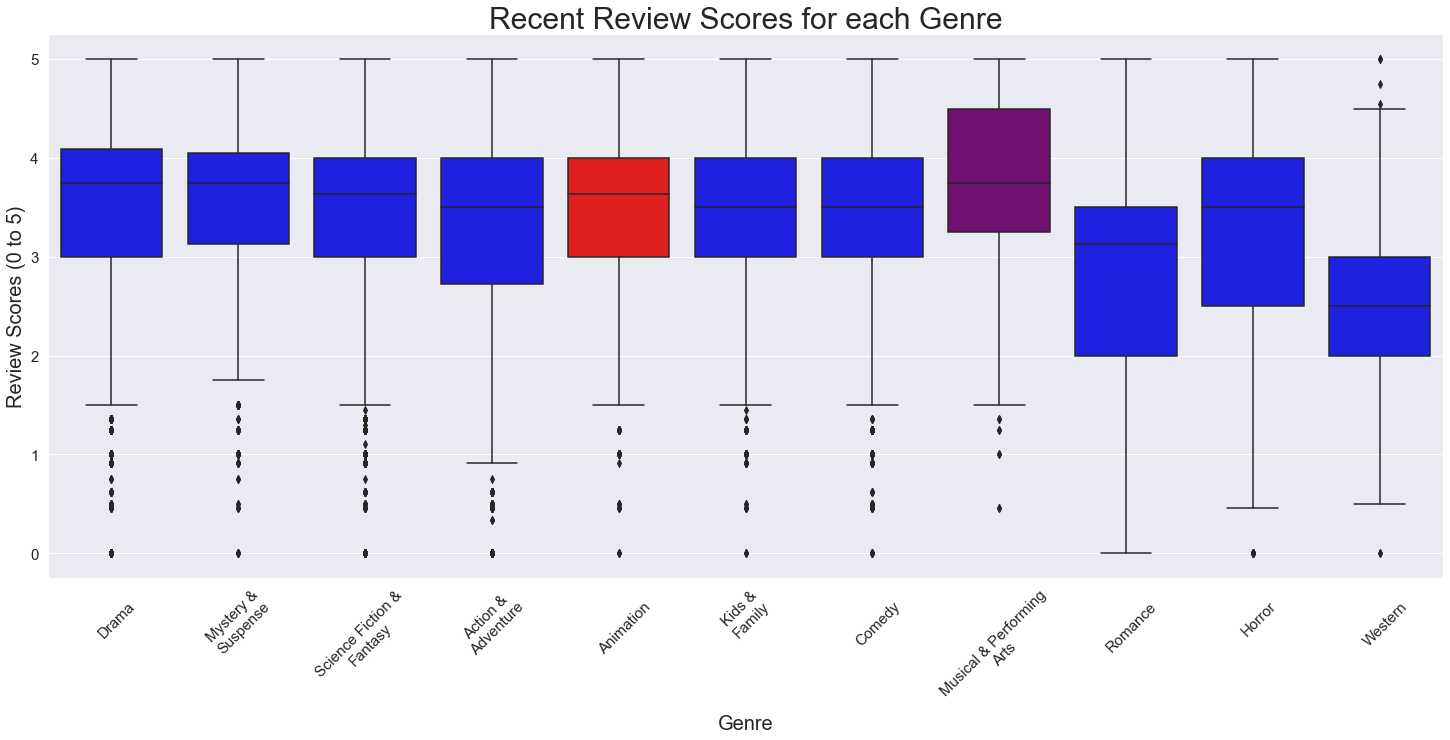

In [54]:
df_genre_edit_rec = copy.deepcopy(df_recgen) #making a copy so we can clean the genre names
df_genre_edit_rec['genres'] = df_genre_edit_rec['genres'].map(lambda x: ' '.join(x.split()[:-1])+'\n'+x.split()[-1]) #cleaning names here

fig6, ax6 = plt.subplots(figsize = (25,10))
ax6 = sns.boxplot(data = df_genre_edit_rec, x = 'genres', y = 'review_score', palette = colorlist(df_genre_edit_rec['genres'].unique()))

ax6.set_title('Recent Review Scores for each Genre', fontsize = 30)
ax6.set_xlabel('Genre', fontsize = 20)
ax6.set_ylabel('Review Scores (0 to 5)', fontsize = 20)
plt.xticks(rotation = 45)
ax6.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/rec_box_sc_gen');

Finally, we make a graph of the "freshness" of each of the genres. We make the grouped series first...

In [55]:
df_g_fb_rec = df_recgen.groupby('genres')['fresh_bool'].mean().sort_values(ascending = False)
df_g_fb_rec.index = df_g_fb_rec.index.map(lambda x: x.replace(' ','\n')) #cleaning names again
df_g_fb_rec.head()

genres
Animation                       0.815877
Mystery\n&\nSuspense            0.807248
Musical\n&\nPerforming\nArts    0.788815
Drama                           0.766572
Kids\n&\nFamily                 0.747002
Name: fresh_bool, dtype: float64

And then we plot it.

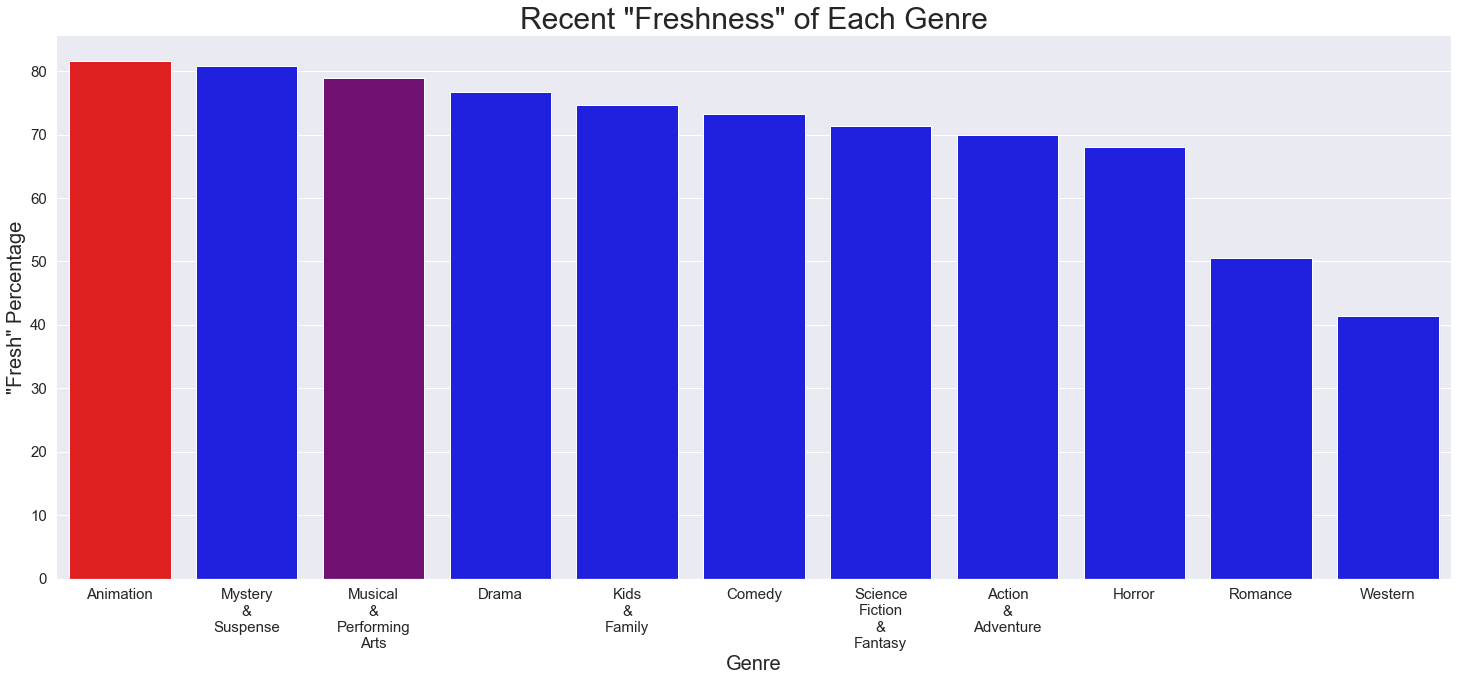

In [56]:
fig7, ax7 = plt.subplots(figsize = (25,10))
ax7 = sns.barplot(x = df_g_fb_rec.index, y = df_g_fb_rec.values*100, palette = colorlist(df_g_fb_rec.index))#the '*100'
                                                                                                        #changes these decimals to percentages

ax7.set_title('Recent "Freshness" of Each Genre', fontsize = 30)
ax7.set_xlabel('Genre', fontsize = 20)
ax7.set_ylabel('"Fresh" Percentage', fontsize = 20)
ax7.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/rec_genre_fresh');

Let's now investigate the most popular actors for animation and musicals

In [57]:
df_recact = df_recgen.loc[df_recgen['genres'].isin(['Animation','Musical & Performing Arts'])].explode('actors')
df_recact.head()

,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,...,tomatometer_count,audience_status,audience_rating,audience_count,top_critic,publisher_name,review_type,review_score,review_date,fresh_bool
rotten_tomatoes_link,,,,,,,,,,,,,,,,,,,,,
m/akira,Akira,R,Animation,[Katsuhiro Ôtomo],"[Katsuhiro Ôtomo, Izo Hashimoto]",Cameron Clarke,"(2020, 9, 24, 0, 0, 0, 3, 268, -1)","(2016, 11, 30, 0, 0, 0, 2, 335, -1)",124.0,Streamline Pictures,...,49.0,Upright,90.0,148559.0,0.0,rec.arts.movies.reviews,Fresh,4.0,"(2000, 1, 1, 0, 0, 0, 5, 1, -1)",True
m/akira,Akira,R,Animation,[Katsuhiro Ôtomo],"[Katsuhiro Ôtomo, Izo Hashimoto]",Mitsuo Iwara,"(2020, 9, 24, 0, 0, 0, 3, 268, -1)","(2016, 11, 30, 0, 0, 0, 2, 335, -1)",124.0,Streamline Pictures,...,49.0,Upright,90.0,148559.0,0.0,rec.arts.movies.reviews,Fresh,4.0,"(2000, 1, 1, 0, 0, 0, 5, 1, -1)",True
m/akira,Akira,R,Animation,[Katsuhiro Ôtomo],"[Katsuhiro Ôtomo, Izo Hashimoto]",Nozomu Sasaki,"(2020, 9, 24, 0, 0, 0, 3, 268, -1)","(2016, 11, 30, 0, 0, 0, 2, 335, -1)",124.0,Streamline Pictures,...,49.0,Upright,90.0,148559.0,0.0,rec.arts.movies.reviews,Fresh,4.0,"(2000, 1, 1, 0, 0, 0, 5, 1, -1)",True
m/akira,Akira,R,Animation,[Katsuhiro Ôtomo],"[Katsuhiro Ôtomo, Izo Hashimoto]",Jan Rabson,"(2020, 9, 24, 0, 0, 0, 3, 268, -1)","(2016, 11, 30, 0, 0, 0, 2, 335, -1)",124.0,Streamline Pictures,...,49.0,Upright,90.0,148559.0,0.0,rec.arts.movies.reviews,Fresh,4.0,"(2000, 1, 1, 0, 0, 0, 5, 1, -1)",True
m/akira,Akira,R,Animation,[Katsuhiro Ôtomo],"[Katsuhiro Ôtomo, Izo Hashimoto]",Lara Cody,"(2020, 9, 24, 0, 0, 0, 3, 268, -1)","(2016, 11, 30, 0, 0, 0, 2, 335, -1)",124.0,Streamline Pictures,...,49.0,Upright,90.0,148559.0,0.0,rec.arts.movies.reviews,Fresh,4.0,"(2000, 1, 1, 0, 0, 0, 5, 1, -1)",True


Let's generate a similar drop list to before.

In [58]:
df_drop_act_rec = df_recact.groupby('actors')['movie_title'].nunique()
drop_list_act_rec = [act for act in df_drop_act_rec.index if df_drop_act_rec[act] <= 2] #any actor who was only in 2 or fewer movies

Now we find the median review score for each actor not in the drop list.

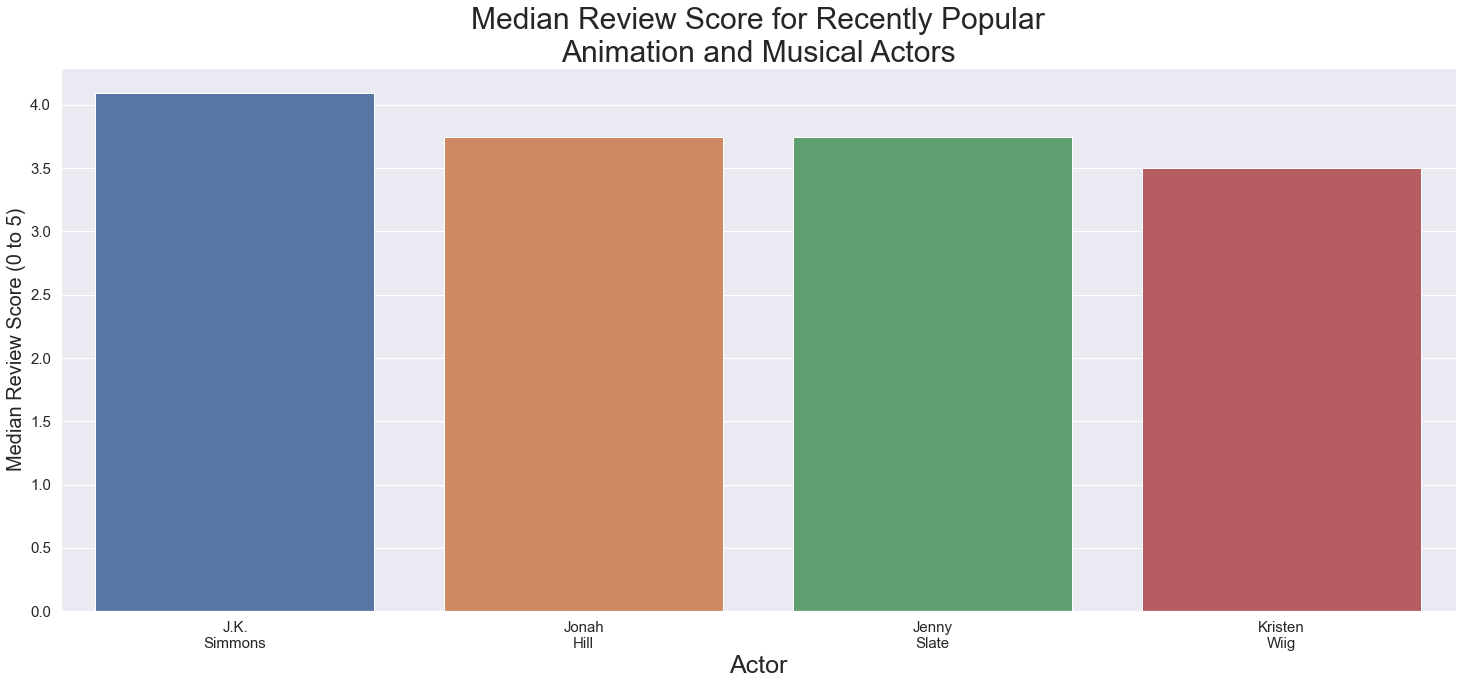

In [59]:
df_ac_sc_rec = df_recact.loc[~df_recact['actors'].isin(drop_list_act_rec)].groupby('actors')['review_score'].median().sort_values(ascending = False)
df_ac_sc_rec.index = df_ac_sc_rec.index.map(lambda x: x.replace(' ','\n')) #fixing names for readability

fig8, ax8 = plt.subplots(figsize=(25,10))
ax8 = sns.barplot(x = df_ac_sc_rec.index, y = df_ac_sc_rec.values)

ax8.set_title('Median Review Score for Recently Popular\nAnimation and Musical Actors', fontsize = 30)
ax8.set_xlabel('Actor', fontsize = 25)
ax8.set_ylabel('Median Review Score (0 to 5)', fontsize = 20)
ax8.tick_params(axis = 'both', labelsize = 15)
plt.savefig('images/rec_median_sc_act');

# Part 2: All the other Tables

In [60]:
df1 = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [61]:
df1['production_budget'] = df1['production_budget'].astype(str)
df1['production_budget'] = df1['production_budget'].map(lambda x: int(x.replace(',','').replace('$','')))
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382","$1,316,721,747"


In [62]:
df1['domestic_gross'] = df1['domestic_gross'].astype(str)
df1['domestic_gross'] = df1['domestic_gross'].map(lambda x: int(x.replace(',','').replace('$','')))
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,"$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,"$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,"$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,"$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,"$1,316,721,747"


In [63]:
df1['worldwide_gross'] = df1['worldwide_gross'].astype(str)
df1['worldwide_gross'] = df1['worldwide_gross'].map(lambda x: int(x.replace(',','').replace('$','')))
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


removed all rows with worldwide gross less than $1000

In [64]:
df1 = df1.loc[df1["worldwide_gross"]>= 1000]
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


Removed all rows with domestic gross less than $1000

In [65]:
df1 = df1.loc[df1["domestic_gross"]>= 1000]
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


Created a profit column

In [66]:
df1["profit"] = df1["worldwide_gross"]-df1["production_budget"]
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


created a profit as percentage column

In [67]:
df1["profit_as_percentage"] = df1["profit"]/df1["production_budget"]*100
df1.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636


In [68]:
df2 = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
df2.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [69]:
df2 = df2.loc[df2["runtime_minutes"]>= 45]
df2.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy


In [70]:
df1 = df1.set_index("movie")

In [71]:
df2 = df2.set_index('primary_title')

Joined title basics and movie budget dataframes

In [72]:
df3=df2.join(df1,on = "primary_title", how= "inner")
df3.head()

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage
primary_title,,,,,,,,,,,,
The Overnight,tt0326592,The Overnight,2010,88.0,NaN,21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792
On the Road,tt2404548,On the Road,2011,90.0,Drama,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792
On the Road,tt3872966,On the Road,2013,87.0,Documentary,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792


Removed rows with null values

In [73]:
df3=df3.dropna()
df3.head()

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage
primary_title,,,,,,,,,,,,
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792
On the Road,tt2404548,On the Road,2011,90.0,Drama,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792
On the Road,tt3872966,On the Road,2013,87.0,Documentary,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792
On the Road,tt4339118,On the Road,2014,89.0,Drama,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792


Made a new column that has unique genres

In [74]:
df3["unique_genres"] = df3["genres"].map(lambda x: x.split(','))
df3.head()

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage,unique_genres
primary_title,,,,,,,,,,,,,
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000,"[Comedy, Mystery]"
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,"[Adventure, Drama, Romance]"
On the Road,tt2404548,On the Road,2011,90.0,Drama,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,[Drama]
On the Road,tt3872966,On the Road,2013,87.0,Documentary,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,[Documentary]
On the Road,tt4339118,On the Road,2014,89.0,Drama,17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,[Drama]


Seperated the different genres

In [75]:
df3 = df3.explode("unique_genres")   
df3.head()

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage,unique_genres
primary_title,,,,,,,,,,,,,
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000,Comedy
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000,Mystery
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,Adventure
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,Drama
On the Road,tt0337692,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013",25000000,720828,9313302,-15686698,-62.746792,Romance


In [76]:
df4 = df3.groupby('unique_genres')['profit_as_percentage'].mean().sort_values()

Made new dataframe with only data from 2015 to current

In [77]:
df3['release_year'] = df3['release_date'].map(lambda x: int(x.split()[-1]))
df5 = df3.loc[df3["release_year"] >= 2015]
df5.head()

,tconst,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,profit_as_percentage,unique_genres,release_year
primary_title,,,,,,,,,,,,,,
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000,Comedy,2015
The Overnight,tt3844362,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015",200000,1109808,1165996,965996,482.998000,Mystery,2015
Jurassic World,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",215000000,652270625,1648854864,1433854864,666.909239,Action,2015
Jurassic World,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",215000000,652270625,1648854864,1433854864,666.909239,Adventure,2015
Jurassic World,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",215000000,652270625,1648854864,1433854864,666.909239,Sci-Fi,2015


In [78]:
df6 = df5.groupby ("unique_genres")["profit_as_percentage"].median()
df6.sort_values(inplace = True)
df6.head()

unique_genres
News      -83.868733
Western    -2.165557
War        10.873340
Sport      43.896543
Crime      69.701800
Name: profit_as_percentage, dtype: float64

Created graph that shows %profit for different genres

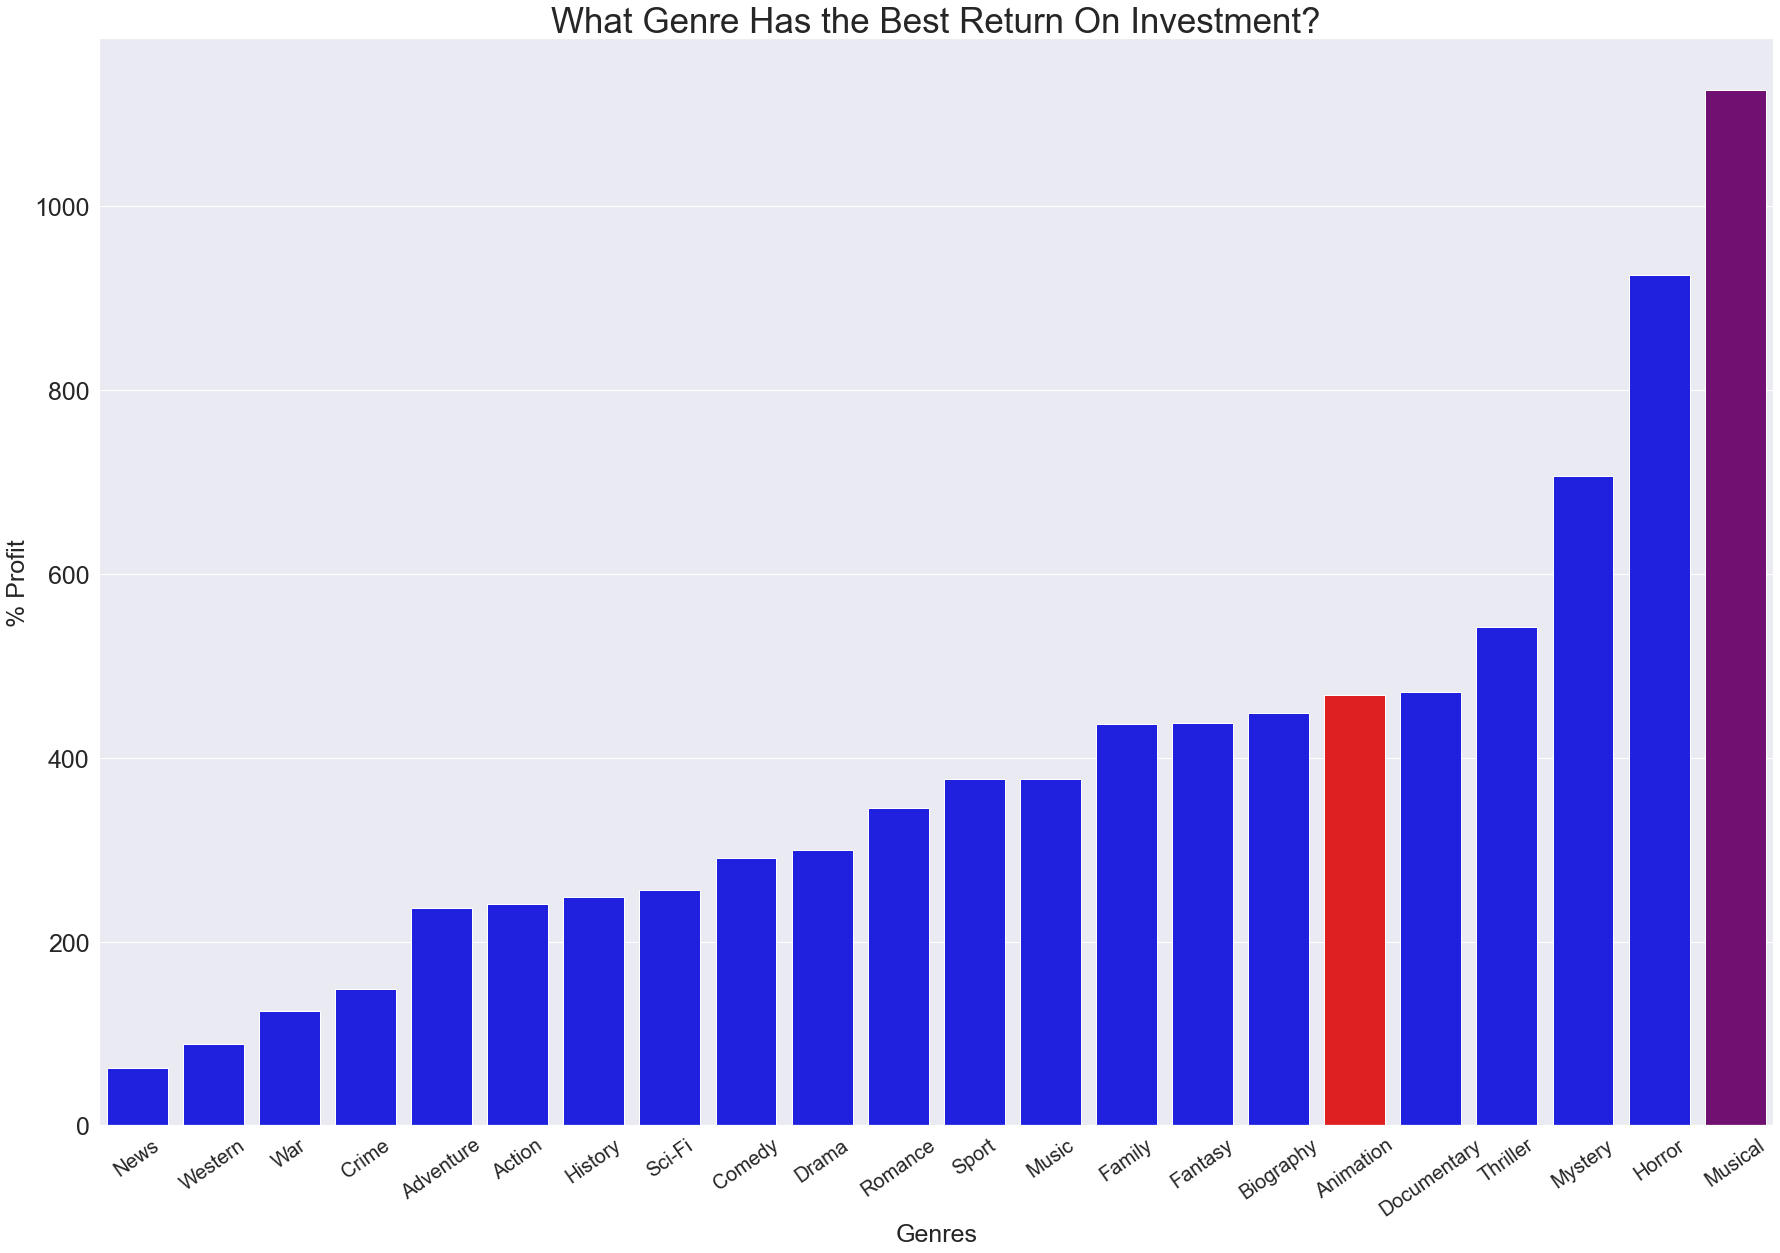

In [79]:
fig, ax =plt.subplots(figsize = (30,20))
ax = sns.barplot(x=df4.index, y=df4.values, palette = colorlist(df4.index))
plt.title("What Genre Has the Best Return On Investment?", fontsize = 35)
plt.ylabel("% Profit", fontsize = 25) 
plt.xlabel("Genres", fontsize = 25)

ax.tick_params(axis = 'y', labelsize = 25)
ax.set_xticklabels(list(df4.index), fontsize = 20, rotation = 35);
plt.savefig('images/Genre_return_on_investment')

Musicals and Animation movies have the highest % return on investment

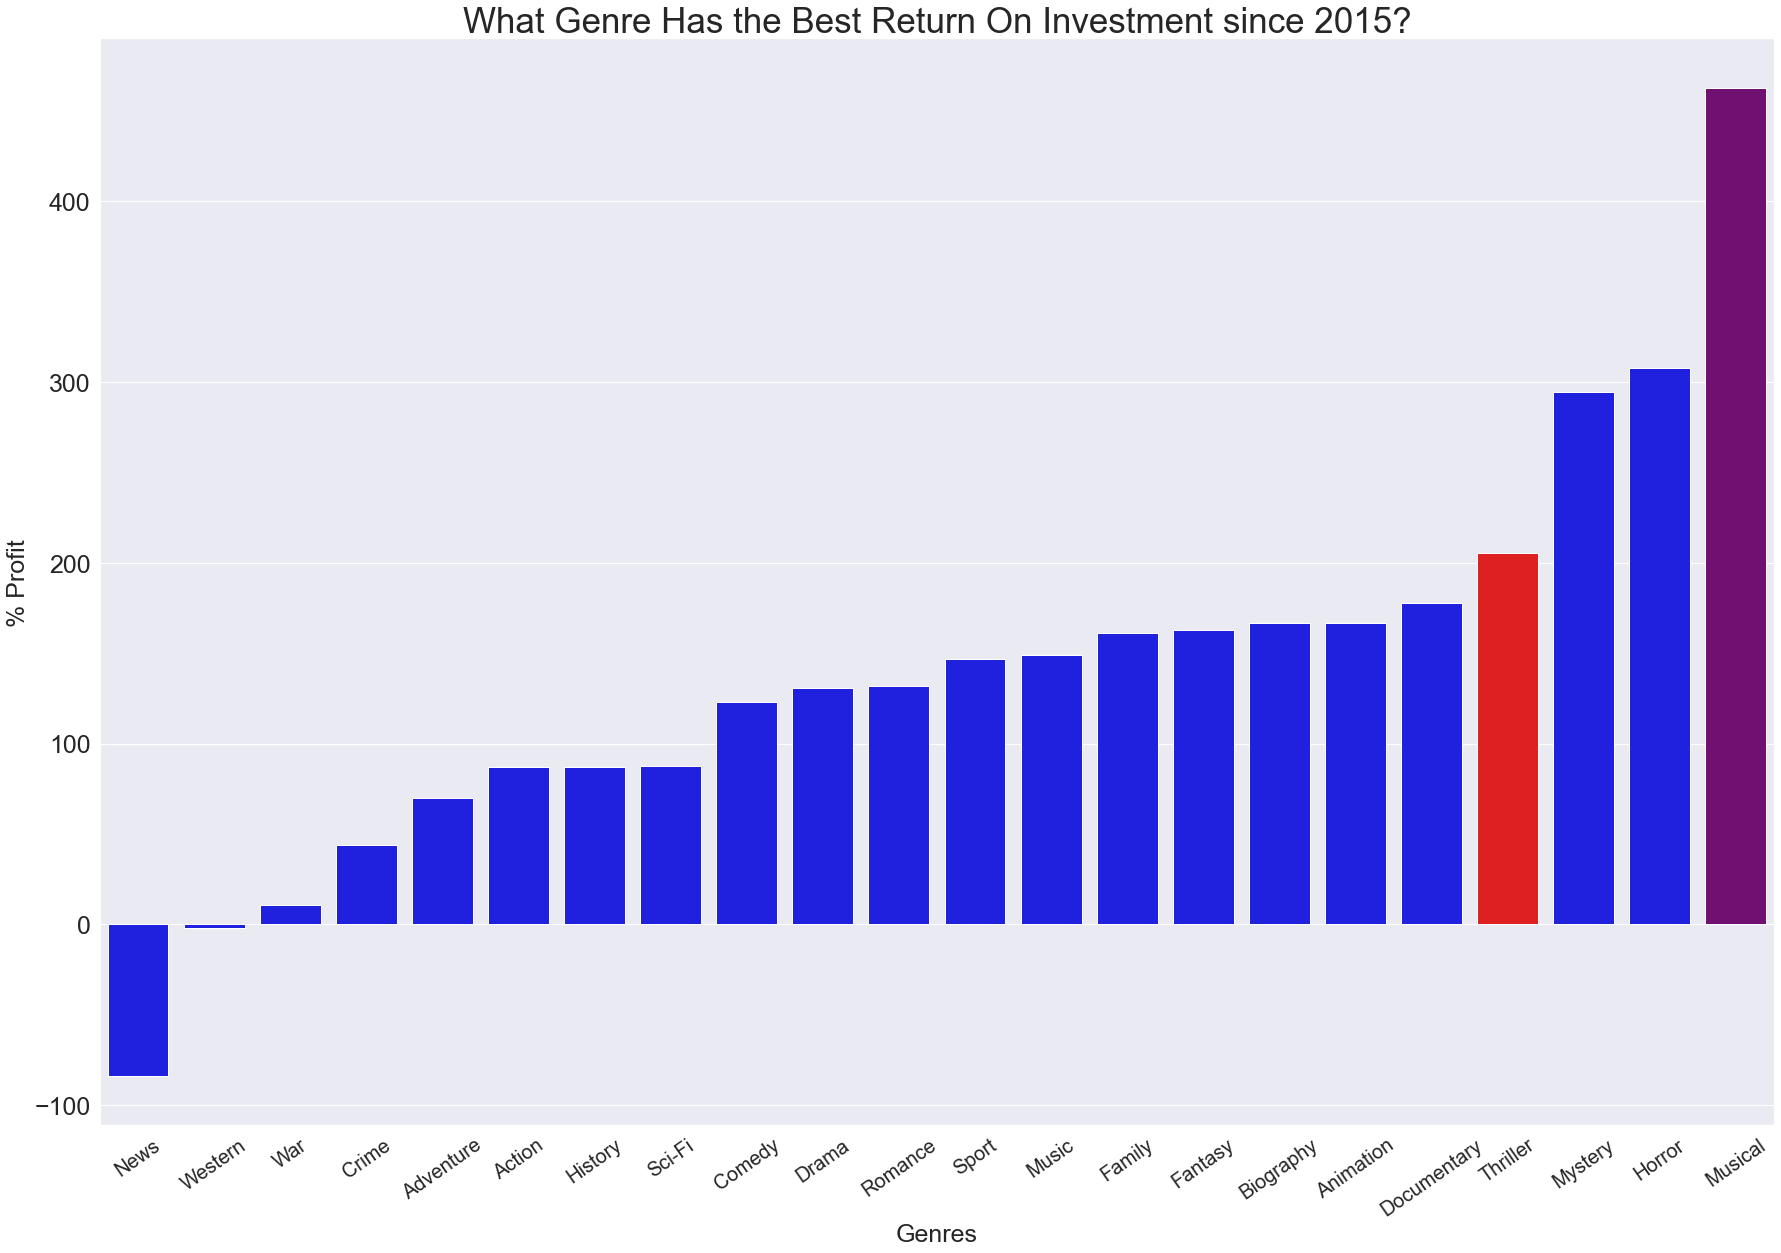

In [80]:
fig, ax =plt.subplots(figsize = (30,20))
ax = sns.barplot(x=df6.index, y=df6.values, palette = colorlist(df6.index))
plt.title("What Genre Has the Best Return On Investment since 2015?", fontsize = 35)
plt.ylabel("% Profit", fontsize = 25) 
plt.xlabel("Genres", fontsize = 25)

ax.tick_params(axis = 'y', labelsize = 25)
ax.set_xticklabels(list(df4.index), fontsize = 20, rotation = 35);
plt.savefig('images/return_on_investment_2015')

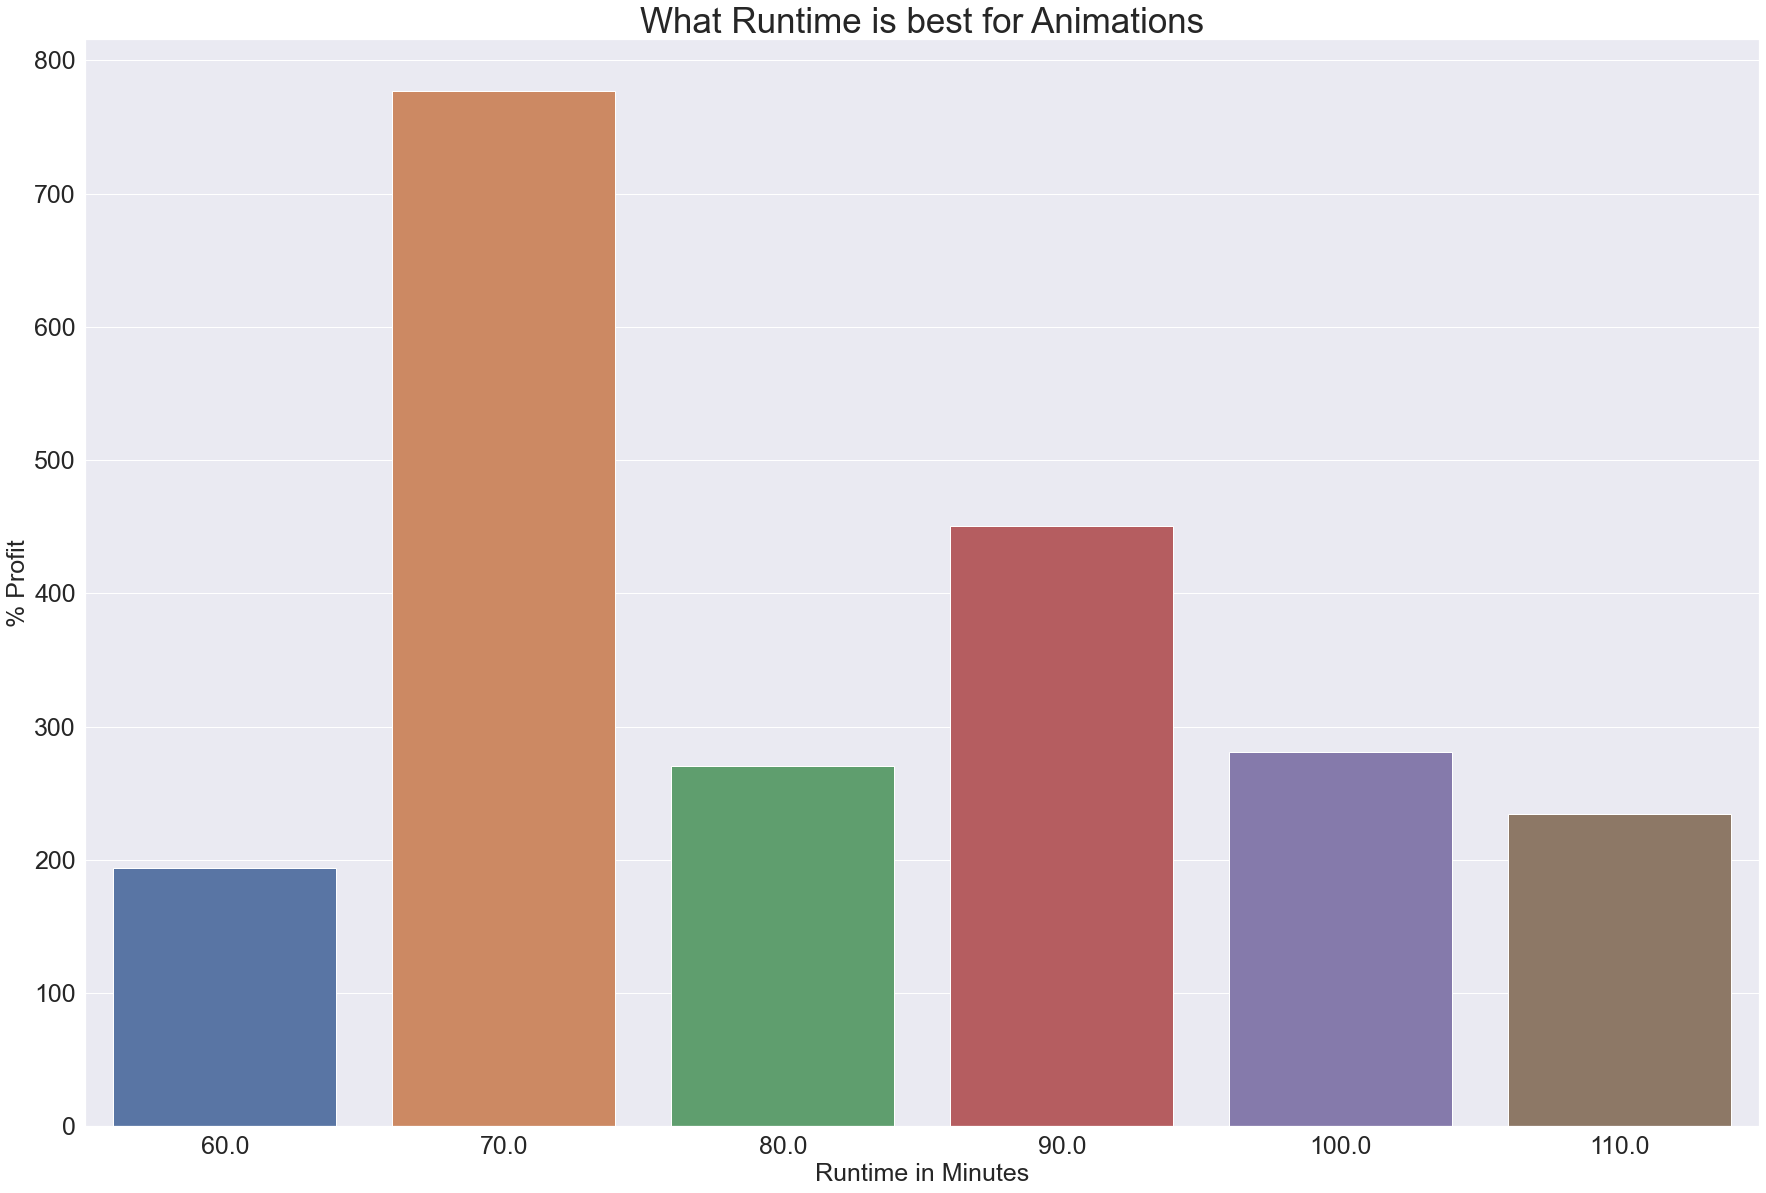

In [81]:
fig, ax = plt.subplots(figsize = (30,20))
df3_filtered = df3.loc[(df3['profit_as_percentage'] < 15000) & (df3['runtime_minutes'] >= 50) & (df3['unique_genres'] == 'Animation')]
df3_filtered['runtime_minutes'] = (df3_filtered['runtime_minutes']//10)*10
df3_filtered = df3_filtered.groupby('runtime_minutes')['profit_as_percentage'].mean()
ax = sns.barplot(x = df3_filtered.index, y = df3_filtered.values)
plt.title("What Runtime is best for Animations", fontsize = 35)
plt.ylabel("% Profit", fontsize = 25) 
plt.xlabel("Runtime in Minutes", fontsize = 25)

ax.tick_params(axis = 'y', labelsize = 25)
ax.tick_params(axis = 'x', labelsize = 25)
plt.savefig('images/animation_runtime')

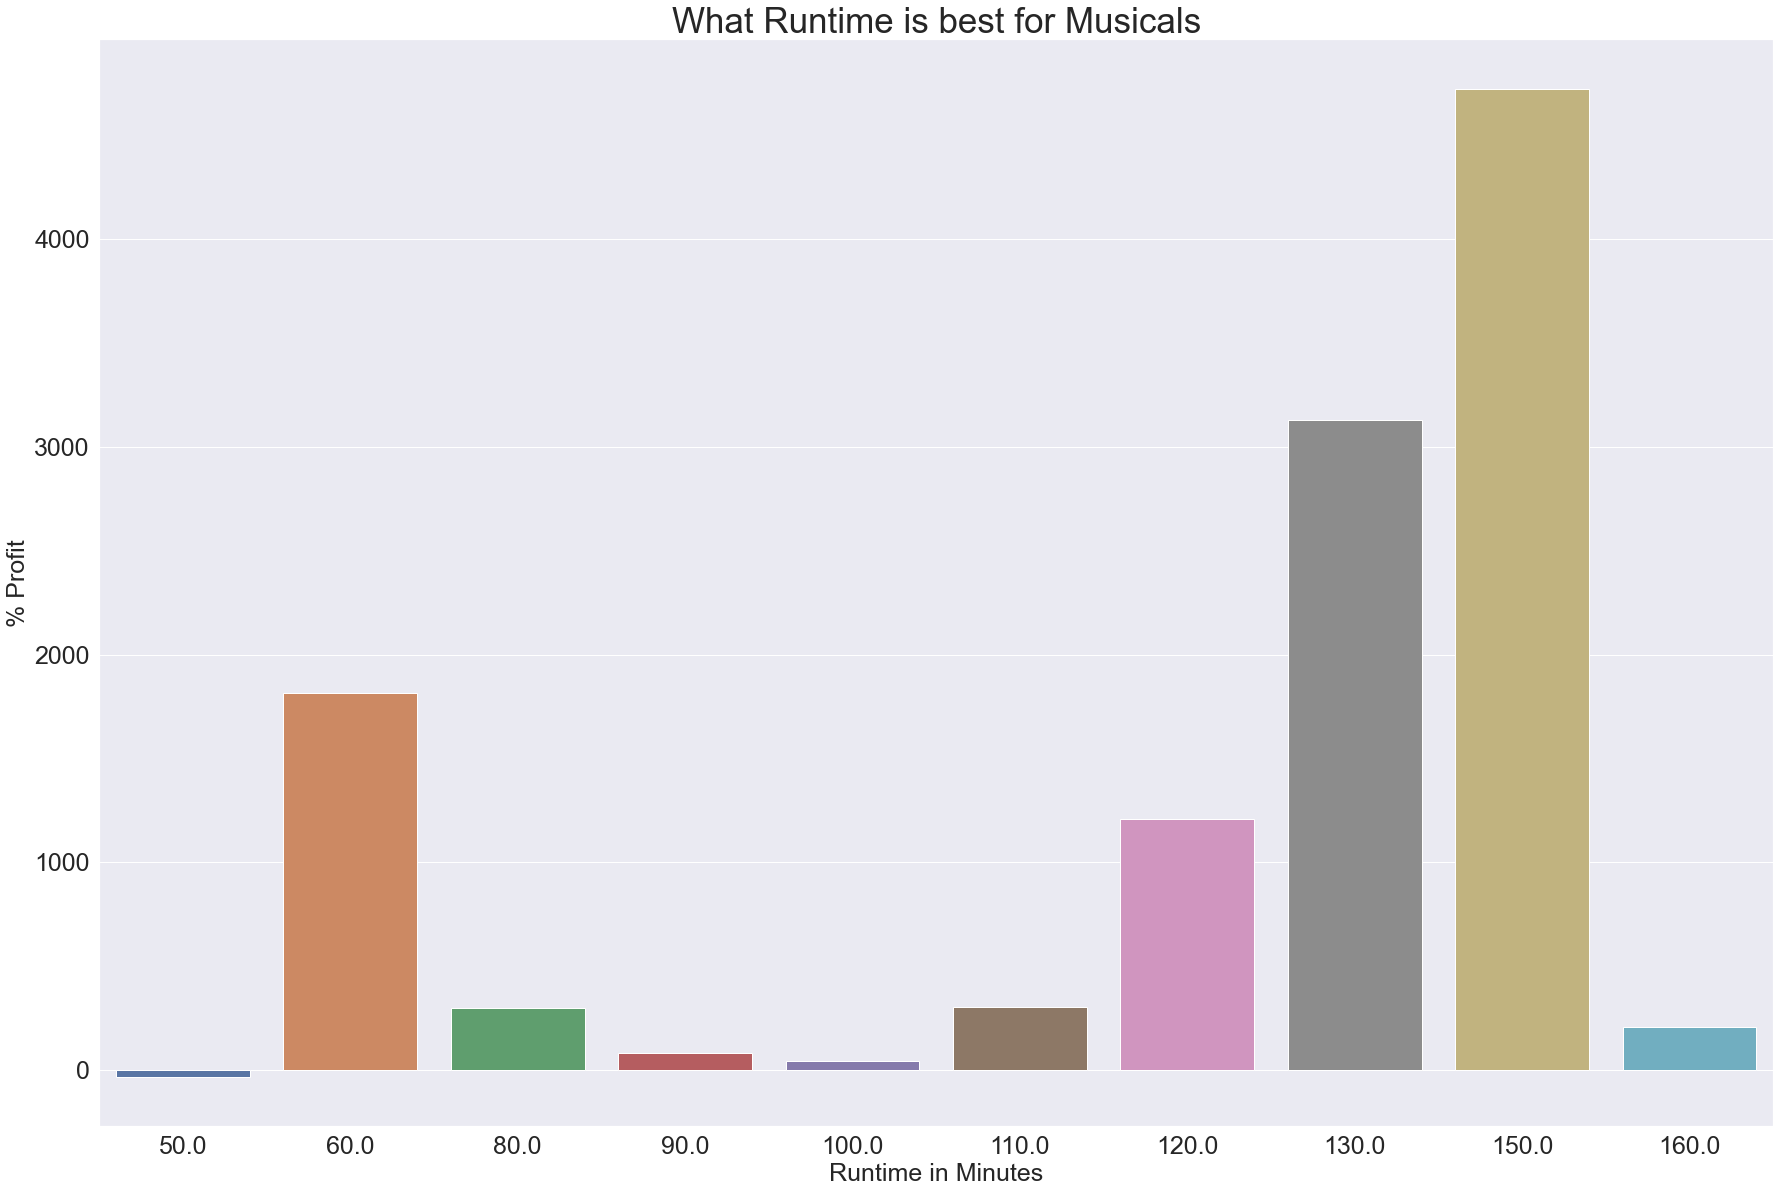

In [82]:
fig, ax = plt.subplots(figsize = (30,20))
df3_filtered = df3.loc[(df3['profit_as_percentage'] < 15000) & (df3['runtime_minutes'] >= 50) & (df3['unique_genres'] == 'Musical')]
df3_filtered['runtime_minutes'] = (df3_filtered['runtime_minutes']//10)*10
df3_filtered = df3_filtered.groupby('runtime_minutes')['profit_as_percentage'].mean()
ax = sns.barplot(x = df3_filtered.index, y = df3_filtered.values)
plt.title("What Runtime is best for Musicals", fontsize = 35)
plt.ylabel("% Profit", fontsize = 25) 
plt.xlabel("Runtime in Minutes", fontsize = 25)

ax.tick_params(axis = 'y', labelsize = 25)
ax.tick_params(axis = 'x', labelsize = 25)
plt.savefig('images/musical_runtime')